In [1]:
push!(LOAD_PATH, "../src")
RIGID_BODY_DYNAMICS_RELEASE = true
using RigidBodyDynamics
using RigidBodyDynamicsSim
using BenchmarkTools

In [2]:
# filename = "/Users/twan/code/julia/RigidBodyDynamics/test/urdf/Acrobot.urdf"
# filename = "/Users/twan/code/drake-distro/drake/examples/Acrobot/Acrobot.urdf"
# filename = "/Users/twan/code/drake-distro/drake/examples/ZMP/CartTable.urdf"
# filename = "/Users/twan/code/drake-distro/drake/examples/Pendulum/Pendulum.urdf"
# filename = "/Users/twan/code/drake-distro/drake/examples/Strandbeest/Strandbeest.urdf"
# filename = "/Users/twan/code/drake-distro/drake/examples/FurutaPendulum/FurutaPendulum.urdf"
# filename = "/Users/twan/Downloads/pelican.xml"
filename = "/Users/twan/code/drake-distro/drake/examples/Atlas/urdf/atlas_minimal_contact.urdf"
mechanism = RigidBodyDynamics.parse_urdf(Float64, filename);

In [3]:
const j = Joint("bla", rand(Revolute{Float64}))
const jt = j.jointType
const q = rand_configuration(j, Float64)
const v = rand(num_velocities(j))

1-element Array{Float64,1}:
 0.572767

In [4]:
@benchmark RigidBodyDynamics.joint_transform($j, $q)

BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     986
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  96.00 bytes
  allocs estimate:  1
  minimum time:     53.00 ns (0.00% GC)
  median time:      55.00 ns (0.00% GC)
  mean time:        64.07 ns (8.49% GC)
  maximum time:     1.80 μs (93.28% GC)

In [4]:
const state = MechanismState(Float64, mechanism);
nq, nv = num_positions(mechanism), num_velocities(mechanism)
const result = DynamicsResult(Float64, mechanism);

In [6]:
using BenchmarkTools
@benchmark dynamics!($result, $state, x) setup = begin rand!($state); x = state_vector($state) end

BenchmarkTools.Trial: 
  samples:          7455
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  123.89 kb
  allocs estimate:  2662
  minimum time:     566.38 μs (0.00% GC)
  median time:      583.69 μs (0.00% GC)
  mean time:        620.21 μs (2.87% GC)
  maximum time:     4.44 ms (79.28% GC)

In [6]:
using BenchmarkTools
@benchmark dynamics!($result, $state, x) setup = begin rand!($state); x = state_vector($state) end

BenchmarkTools.Trial: 
  samples:          6038
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  123.89 kb
  allocs estimate:  2662
  minimum time:     604.37 μs (0.00% GC)
  median time:      748.48 μs (0.00% GC)
  mean time:        767.57 μs (2.66% GC)
  maximum time:     4.88 ms (76.68% GC)

In [8]:
rand_configuration!(state)
zero_velocity!(state)
# zero!(state)
tspan = [0.; 1.]
times, states = simulate(state, tspan, minstep=1e-2, maxstep=1e-2)
# tspan = linspace(0, 1, 100)
# times, states = simulate(state, tspan, integrator = ODE.ode4)
# times, states = simulate(state, tspan)
# tspan = [0.; 5.]
configurations = map(x -> x[1 : num_positions(mechanism)], states);

  0.638298 seconds (2.60 M allocations: 106.631 MB, 2.94% gc time)


In [6]:
# # PROFILEVIEW_USEGTK = true
# Profile.clear()
# @profile times, states = simulate(state, tspan, minstep=1e-2, maxstep=1e-2)
# # Profile.print()
# using ProfileView
# ProfileView.view()

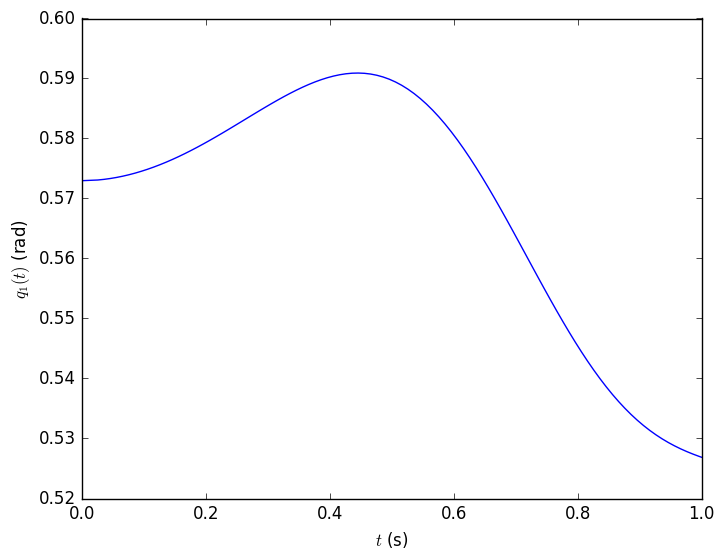

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [13]:
using PyPlot
plot(times, map(x -> x[1], states))
xlabel(L"$t$ (s)"); ylabel(L"$q_1(t)$ (rad)");

In [8]:
using RigidBodyTreeInspector
visualizer = RigidBodyTreeInspector.parse_urdf(filename, mechanism)
animate(visualizer, mechanism, times, configurations; fps = 30., realtimerate = 1.)

In [ ]:
# loop joints beginning
using FixedSizeArrays
import RigidBodyDynamics: exponential_coordinates
joint = joints(mechanism)[4]
S = Array(motion_subspace(joint, configuration(state, joint)))
TArray = nullspace(S')
Tangular = Mat(TArray[1:3, :])
Tlinear = Mat(TArray[4:6, :])
# H = relative_transform(state, joint.frameAfter, joint.frameBefore)
H = rand(Transform3D{Float64}, joint.frameAfter, joint.frameBefore)
d = Vec(exponential_coordinates(H.rot)..., H.trans...)
δ = Tangular' * exponential_coordinates(H.rot) + Tlinear' * H.trans
joint_twist = transform(state, relative_twist(state, joint.frameAfter, joint.frameBefore), joint.frameAfter)
vδ = Tangular' * joint_twist.angular + Tlinear' * joint_twist.linear
Tstab = 1e-2
α = β = 1 / Tstab
kstab = -2 * α * vδ - β^2 * δ
succ = successor(mechanism, joint)
prec = predecessor(mechanism, joint)
pth = path(mechanism, succ, prec)
jac = transform(state, geometric_jacobian(state, pth), joint.frameAfter)
Kcompact = Tangular' * jac.angular + Tlinear' * jac.linear
num_loop_constraints = 6 - num_velocities(joint)
K = zeros(Float64, num_loop_constraints, num_velocities(mechanism))


In [ ]:
# using ForwardDiff
# T = ForwardDiff.Dual{1,ForwardDiff.Dual{9,Float64}}
# # @time MechanismState(T, mechanism);
# Profile.clear()
# @profile MechanismState(T, mechanism)
# using ProfileView
# ProfileView.view()

In [11]:
push!(LOAD_PATH, "../src")
using RigidBodyDynamics
using RigidBodyDynamicsSim

using FixedSizeArrays
using Quaternions

# const joint = Joint("bla", QuaternionFloating{Float64}())
const joint = Joint("bla", rand(Revolute{Float64}))
const q = rand_configuration(joint, Float64)
const jointType = joint.jointType

function test(joint::Joint, q::Vector)
#     T = promote_type(J, Q)
#     ret::Transform3D{T}
    ret = joint_transform(joint, joint.jointType, q)
#     if isa(joint.jointType, QuaternionFloating{J})
#         ret = joint_transform(joint, joint.jointType::QuaternionFloating{J}, q)
#     elseif isa(joint.jointType, Revolute{J})
#         ret = joint_transform(joint, joint.jointType::Revolute{J}, q)
#     else
#         ret = Transform3D{T}(joint.frameBefore, joint.frameAfter)
#     end
    ret
end
# function test{T}(q::Vector{T})
#     @inbounds joint_transform(joint, joint.jointType, q)
# end

test (generic function with 1 method)

In [13]:
using BenchmarkTools
@benchmark test(joint, q) setup = q[:] = rand_configuration(joint, Float64)

BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     976
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  96.00 bytes
  allocs estimate:  1
  minimum time:     68.00 ns (0.00% GC)
  median time:      72.00 ns (0.00% GC)
  mean time:        81.59 ns (7.87% GC)
  maximum time:     2.04 μs (94.55% GC)

In [13]:
a = [1.; 2.]

2-element Array{Float64,1}:
 1.0
 2.0

In [9]:
push!(LOAD_PATH, "../src")
RIGID_BODY_DYNAMICS_RELEASE = true
using RigidBodyDynamics
using BenchmarkTools

In [10]:
function bla{T}(::Type{T})
    types = RigidBodyDynamics.ConcreteSubtypes(Vector{T})
#     RigidBodyDynamics.@DynamicDispatch a::JointType{Float64} begin sum(a) end
end

bla (generic function with 1 method)

In [11]:
@benchmark bla(Float64)

BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     979
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  112.00 bytes
  allocs estimate:  2
  minimum time:     65.00 ns (0.00% GC)
  median time:      68.00 ns (0.00% GC)
  mean time:        79.41 ns (7.29% GC)
  maximum time:     1.69 μs (92.89% GC)

In [6]:
macro joint_type_dependent_function(signature)
    functionName = signature.args[1]
    functionArgs = signature.args[2:end]
    quote
        function $(functionName){J}(joint::Joint{J}, $(functionArgs...))
            # ret::$(returnType)
            jointType = joint.jointType
            if isa(jointType, Fixed{J})
                ret = $functionName(joint, joint.jointType::Fixed{J}, $(functionArgs...))
            elseif isa(jointType, Revolute{J})
                ret = $functionName(joint, joint.jointType::Revolute{J}, $(functionArgs...))
            elseif isa(jointType, Prismatic{J})
                ret = $functionName(joint, joint.jointType::Prismatic{J}, $(functionArgs...))
            elseif isa(jointType, QuaternionFloating{J})
                ret = $functionName(joint, joint.jointType::QuaternionFloating{J}, $(functionArgs...))
            end
            ret
        end
    end
end

In [7]:
@joint_type_dependent_function joint_transform(q::AbstractVector)

#197#joint_transform (generic function with 1 method)

In [4]:
methods(joint_transform)

# 4 methods for generic function "joint_transform":
joint_transform{T<:Real}(j::RigidBodyDynamics.Joint{T<:Real}, jt::RigidBodyDynamics.QuaternionFloating{T<:Real}, q::AbstractArray{T<:Real,1}) at /Users/twan/code/julia/RigidBodyDynamicsSim/packages/v0.4/RigidBodyDynamics/src/joint.jl:69
joint_transform{T1<:Real,T2}(j::RigidBodyDynamics.Joint{T<:Real}, jt::RigidBodyDynamics.Prismatic{T2}, q::AbstractArray{T1<:Real,1}) at /Users/twan/code/julia/RigidBodyDynamicsSim/packages/v0.4/RigidBodyDynamics/src/joint.jl:137
joint_transform{T1,T2}(j::RigidBodyDynamics.Joint{T<:Real}, jt::RigidBodyDynamics.Revolute{T2}, q::AbstractArray{T1,1}) at /Users/twan/code/julia/RigidBodyDynamicsSim/packages/v0.4/RigidBodyDynamics/src/joint.jl:156
joint_transform{T}(j::RigidBodyDynamics.Joint{T<:Real}, jt::RigidBodyDynamics.Fixed{T<:Real}, q::AbstractArray{T,1}) at /Users/twan/code/julia/RigidBodyDynamicsSim/packages/v0.4/RigidBodyDynamics/src/joint.jl:186

In [10]:
expr = :(joint_transform{J, X}(joint::Joint{J}, q::AbstractVector{X})::Transform3D{promote_type(J, T)})

:(joint_transform{J,X}(joint::Joint{J},q::AbstractVector{X})::Transform3D{promote_type(J,T)})

In [11]:
expr.args

2-element Array{Any,1}:
 :(joint_transform{J,X}(joint::Joint{J},q::AbstractVector{X}))
 :(Transform3D{promote_type(J,T)})                            

In [15]:
expr.head == :(::)

true

4-element Array{Expr,1}:
 :((RigidBodyDynamics.Fixed){J})             
 :((RigidBodyDynamics.Prismatic){J})         
 :((RigidBodyDynamics.Revolute){J})          
 :((RigidBodyDynamics.QuaternionFloating){J})

In [40]:
macro joint_type_dependent_function(signature)
    @assert signature.head == :(::)
    functionCall = signature.args[1]
    @assert functionCall.head == :call
    returnType = signature.args[2]
    functionWithParams = functionCall.args[1]
    functionName = functionWithParams.args[1]
    functionArgs = functionCall.args[2:end]
    argsWithoutType = [arg.args[1] for arg in functionArgs]
    joint = argsWithoutType[1]
    J = functionArgs[1].args[2].args[2]
    jointTypes = [:($(typ.name){$J}) for typ in mostSpecificSubTypes(JointType)]
    ret = quote
        function $(functionWithParams)($(functionArgs...))
            ret::$(returnType)
            jointType = $(joint).jointType
            if isa(jointType, Fixed{J})
            ret = $functionName($joint, $(joint).jointType::Fixed{$(J)}, $(argsWithoutType...))
            elseif isa(jointType, Revolute{J})
                ret = $functionName($joint, $(joint).jointType::Revolute{$(J)}, $(argsWithoutType...))
            elseif isa(jointType, Prismatic{J})
                ret = $functionName($joint, $(joint).jointType::Prismatic{$(J)}, $(argsWithoutType...))
            elseif isa(jointType, QuaternionFloating{J})
                ret = $functionName($joint, $(joint).jointType::QuaternionFloating{$(J)}, $(argsWithoutType...))
            else
                ret = $(returnType)()
            end
            ret
        end
    end
    println(ret)
end

In [41]:
bla = @joint_type_dependent_function joint_transform{J, X}(j::Joint{J}, q::AbstractVector{X})::Transform3D{promote_type(J, X)}

begin  # In[40], line 14:
    function joint_transform{J,X}(j::Joint{J},q::AbstractVector{X}) # In[40], line 15:
        ret::Transform3D{promote_type(J,X)} # In[40], line 16:
        jointType = j.jointType # In[40], line 17:
        if isa(jointType,Fixed{J}) # In[40], line 18:
            ret = joint_transform(j,j.jointType::Fixed{J},j,q)
        else  # In[40], line 19:
            if isa(jointType,Revolute{J}) # In[40], line 20:
                ret = joint_transform(j,j.jointType::Revolute{J},j,q)
            else  # In[40], line 21:
                if isa(jointType,Prismatic{J}) # In[40], line 22:
                    ret = joint_transform(j,j.jointType::Prismatic{J},j,q)
                else  # In[40], line 23:
                    if isa(jointType,QuaternionFloating{J}) # In[40], line 24:
                        ret = joint_transform(j,j.jointType::QuaternionFloating{J},j,q)
                    else  # In[40], line 26:
                        ret = Transform3D{promote_type(J,X)}(

In [37]:
bla

#212#joint_transform (generic function with 1 method)

In [26]:
signature = :(joint_transform{J, X}(j::Joint{J}, q::AbstractVector{X})::Transform3D{promote_type(J, X)})

:(joint_transform{J,X}(j::Joint{J},q::AbstractVector{X})::Transform3D{promote_type(J,X)})

In [29]:
signature.args[1].head

:call

In [23]:
functionCall = signature.args[1]
returnType = signature.args[2]
functionWithParams = functionCall.args[1]
functionName = functionWithParams.args[1]
functionArgs = functionCall.args[2:end]
argsWithoutType = [arg.args[1] for arg in functionArgs]
joint = argsWithoutType[1]
J = functionArgs[1].args[2].args[2]
argsWithoutType = argsWithoutType[2:end] # skip joint

1-element Array{Any,1}:
 :q

In [3]:
# abstract JointType{T}
# immutable QuaternionFloating{T}<:JointType{T} end
# type Joint{JT<:JointType}
#     jt::JT
# end

In [4]:
scalartype{T<:JointType}(t::Type{T}) = t.parameters[1]

scalartype (generic function with 1 method)

In [4]:
function concreteSubTypes(T::DataType)
    types = DataType[]
    if isleaftype(T)
        push!(types, T)
    else
        for S in subtypes(T)
            if S != T   # guard against infinite recursion, Any is a subtype of itself
                append!(types, concreteSubTypes(S))
            end
        end
    end
    return types
end

concreteSubTypes (generic function with 1 method)

In [4]:
typealias JointTypesUnion{T} Union{RigidBodyDynamics.Fixed{T},RigidBodyDynamics.Prismatic{T},RigidBodyDynamics.QuaternionFloating{T},RigidBodyDynamics.Revolute{T}}

Union{RigidBodyDynamics.Fixed{T},RigidBodyDynamics.Prismatic{T},RigidBodyDynamics.QuaternionFloating{T},RigidBodyDynamics.Revolute{T}}

In [5]:
function delegate{T}(joint::Joint{T}, jt::JointTypesUnion{T}, q, v)
    bias_acceleration(joint.frameAfter, joint.frameBefore, jt, q, v)
end

delegate (generic function with 1 method)

In [6]:
const js = joints(mechanism)
function test()
    for j in js
        delegate(j, j.jointType, q, v)
    end
end

test (generic function with 1 method)

In [7]:
jt2 = j.jointType::JointTypesUnion

Revolute joint with axis Vec(0.01479385771837995,0.677032407400846,0.7358044992406768)

In [9]:
@benchmark test()

BenchmarkTools.Trial: 
  samples:          10000
  evals/sample:     9
  time tolerance:   5.00%
  memory tolerance: 1.00%
  memory estimate:  4.61 kb
  allocs estimate:  59
  minimum time:     2.38 μs (0.00% GC)
  median time:      2.46 μs (0.00% GC)
  mean time:        2.77 μs (8.68% GC)
  maximum time:     142.58 μs (97.87% GC)

In [21]:
@generated function joint_transform_impl{J, JT}(joint::Joint{J}, jointType::JT, q)
#     X = eltype(q)
    types = concreteSubTypes(JointType{J})
    for t in types
        if t == JT
            ret = :(joint_transform(joint, joint.jointType::$(t), q)::Transform3D{J})
            println(ret )
            return ret
        end
    end
end

joint_transform_impl (generic function with 1 method)

In [22]:
ret = joint_transform_impl(j, j.jointType, q)

joint_transform(joint,joint.jointType::RigidBodyDynamics.Revolute{Float64},q)::Transform3D{J}


Transform3D from "after_back_bkz" to "before_back_bkz":
rotation: 0.13524369933672575 rad about [0.0,0.0,0.9999999999999959], translation: Vec(0.0,0.0,0.0)


In [7]:
t = typeof(j)

Joint{QuaternionFloating{Float64}}

In [10]:
t.parameters[1].parameters[1]

Float64

In [17]:
b = 

Union{RigidBodyDynamics.Fixed{Float64},RigidBodyDynamics.Prismatic{Float64},RigidBodyDynamics.QuaternionFloating{Float64},RigidBodyDynamics.Revolute{Float64}}

In [18]:
b.types

svec(RigidBodyDynamics.Prismatic{Float64},RigidBodyDynamics.Revolute{Float64},RigidBodyDynamics.Fixed{Float64},RigidBodyDynamics.QuaternionFloating{Float64})

In [36]:
@generated function joint_transform_dispatch{J}(j, jt::JointType{J}, q)
    for t in RigidBodyDynamics.JointTypesUnion{J}.types
        if t == jt
            println(t)
            return :(joint_transform(j.frameAfter, j.frameBefore, jt::$(jt), q))
        end
    end
end

joint_transform_dispatch (generic function with 1 method)

In [40]:
j = joints(mechanism)[3]

Joint "back_bkx": Revolute joint with axis Vec(1.0,0.0,0.0)

In [48]:
function test()
    js = joints(mechanism)
    for i = 1 : 10000
        for joint in js
            joint_transform_dispatch(j, (j.jointType), q)
        end
    end
end

test (generic function with 1 method)

In [58]:
@time test()

  0.053287 seconds (590.01 k allocations: 54.017 MB, 9.80% gc time)


In [43]:
@code_llvm joint_transform_dispatch(j, (j.jointType), q)


define void @julia_joint_transform_dispatch_22744(%Transform3D* sret, %jl_value_t*, %Revolute*, %jl_value_t*) {
top:
  %jt = alloca %Revolute, align 8
  %4 = alloca %Transform3D, align 8
  %5 = alloca %CartesianFrame3D, align 8
  %6 = alloca %CartesianFrame3D, align 8
  %7 = load %Revolute* %2, align 8
  store %Revolute %7, %Revolute* %jt, align 8
  %8 = getelementptr %jl_value_t* %1, i64 2
  %9 = bitcast %jl_value_t* %8 to %CartesianFrame3D*
  %10 = load %CartesianFrame3D* %9, align 16
  store %CartesianFrame3D %10, %CartesianFrame3D* %5, align 8
  %11 = getelementptr %jl_value_t* %1, i64 1
  %12 = bitcast %jl_value_t* %11 to %CartesianFrame3D*
  %13 = load %CartesianFrame3D* %12, align 8
  store %CartesianFrame3D %13, %CartesianFrame3D* %6, align 8
  call void @julia_joint_transform_22165(%Transform3D* sret %4, %CartesianFrame3D* %5, %CartesianFrame3D* %6, %Revolute* %jt, %jl_value_t* %3)
  %14 = load %Transform3D* %4, align 8
  store %Transform3D %14, %Transform3D* %0, align 8
  re

In [10]:
promote(1., 1)

(1.0,1.0)